# PREDIKSI SALES

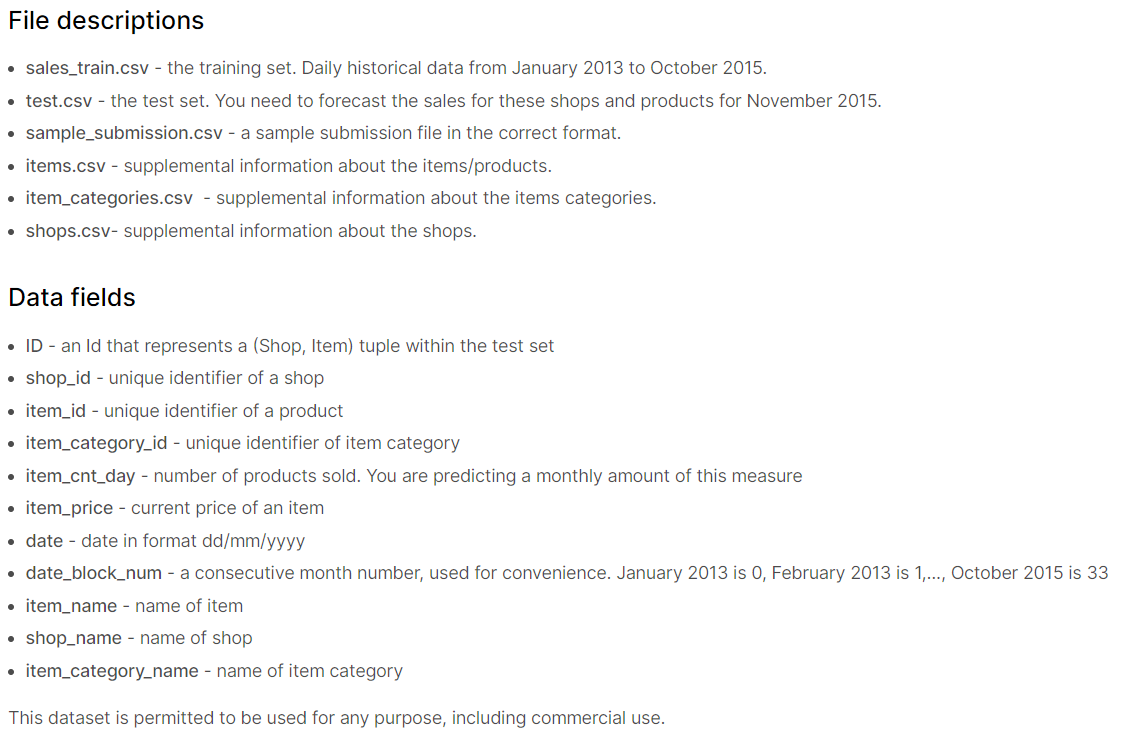

# Import basic library

saya import os biasanya buat cek working directory pakai syntaxs os.getcwd() <br>
lalu pakai numpy untuk ngolah2 array <br>
pakai pandas buat manipulasi table kyk SQL <br>
pakai random ya buat nge-randomin data <br>
import datetime ini buat ngubah table isi tanggal ke object date <br>

buat visualisasi matplotlib.pyplot buat bikin2 grafik2 <br>
import sklearn buat import machine learning sederhana <br>
import fbprophet buat ambil machine learning dari facebook(meta) Khusus untuk regresi

In [1]:
# basic library
import os
import numpy as np
import pandas as pd
import random as rd
import datetime

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from fbprophet import Prophet

In [2]:
item_categories = pd.read_csv('item_categories.csv')
items           = pd.read_csv('items.csv')
sales           = pd.read_csv('sales_train.csv')
shops           = pd.read_csv('shops.csv')
# set index to ID to avoid droping it later
test            = pd.read_csv('test.csv').set_index('ID')

ini kita coba intip datasetnya pakai df.head() atau df.tail()
defaultyna keluar 5 row aja tapi bisa disetel pakai df.head(15) keluar 15 row

In [3]:
item_categories.tail()

item_category_name  item_category_id
79                  Служебные                79
80         Служебные - Билеты                80
81    Чистые носители (шпиль)                81
82  Чистые носители (штучные)                82
83           Элементы питания                83

In [4]:
items.head()

item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40

In [5]:
sales.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0

In [6]:
shops.head()

shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4

In [7]:
test.head()

shop_id  item_id
ID                  
0         5     5037
1         5     5320
2         5     5233
3         5     5232
4         5     5268

Count top 10 for item per category 

In [8]:
item_cat=items.groupby(['item_category_id']).count().sort_values(by='item_id',ascending=False)
# item_cat=item_cat.head(10).reset_index(inplace=False)
item_cat=item_cat.head(10).reset_index(inplace=False)
item_cat

item_category_id  item_name  item_id
0                40       5035     5035
1                55       2365     2365
2                37       1780     1780
3                31       1125     1125
4                58        790      790
5                30        756      756
6                72        666      666
7                19        628      628
8                61        598      598
9                23        501      501

# Simple EDA (Exploratory Data Analysis)

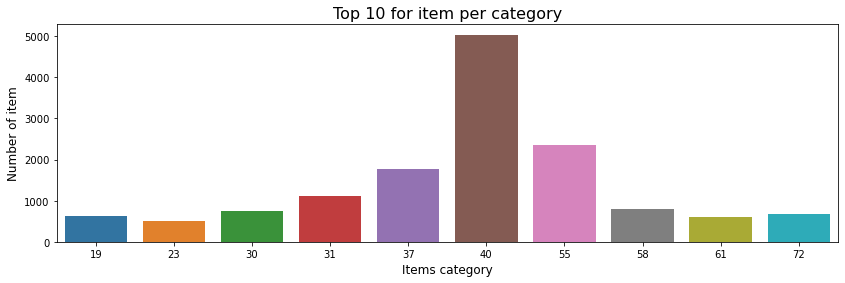

In [9]:
# plot table category
plt.figure(figsize = (14,4))
ax = sns.barplot(x = item_cat.item_category_id, y = item_cat.item_id )
plt.title('Top 10 for item per category', fontsize = 16)
plt.xlabel('Items category', fontsize = 12)
plt.ylabel('Number of item', fontsize = 12)
plt.show()

Disini kita bisa melihat bahwa item dengan kategori nomor 40 memiliki jumlah item variasi paling banyak. Akan tetapi jumlah variasi item paling banyak bukan berarti paling laku di pasaran.

disini saya tertarik buat menganalisis toko paling populer `shop_id` dari data penjualan orang russia itu. Popularitas sebuah toko ditentukan oleh banyaknya transaksi yang terjadi. Kuy kita buat tabel frekuensi menggunakan `.value_counts()` sebagai berikut:

In [10]:
top_3_shop = sales['shop_id'].value_counts().head(3)
top_3_shop

31    235636
25    186104
54    143480
Name: shop_id, dtype: int64

Disini kita filter table sales dengan top 3 id toko kita

In [11]:
sales_top_3_shop = sales[sales['shop_id'].isin(top_3_shop.index)]
sales_top_3_shop

date  date_block_num  shop_id  item_id  item_price  \
1        03.01.2013               0       25     2552      899.00   
2        05.01.2013               0       25     2552      899.00   
3        06.01.2013               0       25     2554     1709.05   
4        15.01.2013               0       25     2555     1099.00   
5        10.01.2013               0       25     2564      349.00   
...             ...             ...      ...      ...         ...   
2935844  10.10.2015              33       25     7409      299.00   
2935845  09.10.2015              33       25     7460      299.00   
2935846  14.10.2015              33       25     7459      349.00   
2935847  22.10.2015              33       25     7440      299.00   
2935848  03.10.2015              33       25     7460      299.00   

         item_cnt_day  
1                 1.0  
2                -1.0  
3                 1.0  
4                 1.0  
5                 1.0  
...               ...  
2935844           1.0  
2935845           1.0  
2935846           1.0  
2935847           1.0  
2935848           1.0  

[565220 rows x 6 columns]

ternyata disini kita dapat melihat toko dengan urutan frekuensi yang paling tinggi adalah toko dengan id 31, 25, 54

Dibawah ini kita akan memakai machine learning fbProphet dari Facebook (Meta). data yang kita pakai cuma dari table sales dulu.

In [12]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [13]:
sales['date'] = pd.to_datetime(sales['date'], dayfirst=True, errors='coerce')
sales['total_revenue'] = sales['item_price'] * sales['item_cnt_day']
sales_1 = sales.sort_values('date')
sales_1['month'] = sales_1['date'].dt.month
sales_1['year'] = sales_1['date'].dt.year
sales_1

date  date_block_num  shop_id  item_id  item_price  \
49800   2013-01-01               0       18     5823      2500.0   
29784   2013-01-01               0       27     5573       849.0   
35476   2013-01-01               0        7     1006       399.0   
8330    2013-01-01               0       19    17707       899.0   
57384   2013-01-01               0       14    19548       149.0   
...            ...             ...      ...      ...         ...   
2885098 2015-10-31              33       41    21386       169.0   
2930981 2015-10-31              33       21      988       199.0   
2885097 2015-10-31              33       41    21377       169.0   
2930993 2015-10-31              33       22    10207      1199.0   
2928850 2015-10-31              33       24     3042      3199.0   

         item_cnt_day  total_revenue  month  year  
49800             1.0         2500.0      1  2013  
29784             1.0          849.0      1  2013  
35476             1.0          399.0      1  2013  
8330              1.0          899.0      1  2013  
57384             1.0          149.0      1  2013  
...               ...            ...    ...   ...  
2885098           1.0          169.0     10  2015  
2930981           1.0          199.0     10  2015  
2885097           1.0          169.0     10  2015  
2930993           1.0         1199.0     10  2015  
2928850           1.0         3199.0     10  2015  

[2935849 rows x 9 columns]

In [14]:
sales_2 = sales_1.groupby(['date','shop_id'])[['item_cnt_day','total_revenue']].sum().reset_index().rename({'item_cnt_day':'total_qty'}, axis = 'columns')
sales_2.head()

date  shop_id  total_qty  total_revenue
0 2013-01-01        2       24.0        31886.0
1 2013-01-01        7       89.0        59993.0
2 2013-01-01        8       50.0        44516.0
3 2013-01-01       13       31.0         6043.0
4 2013-01-01       14       66.0        48847.0

---

# Multiple Time Series Analysis

In [15]:
sales_3 = sales_2[sales_2['shop_id'].isin(top_3_shop.index)]
sales_3.head()

date  shop_id  total_qty  total_revenue
16 2013-01-01       54      415.0      316557.00
34 2013-01-02       25      568.0      345174.13
40 2013-01-02       31      568.0      396376.10
55 2013-01-02       54      709.0      519336.00
78 2013-01-03       25      375.0      249421.00

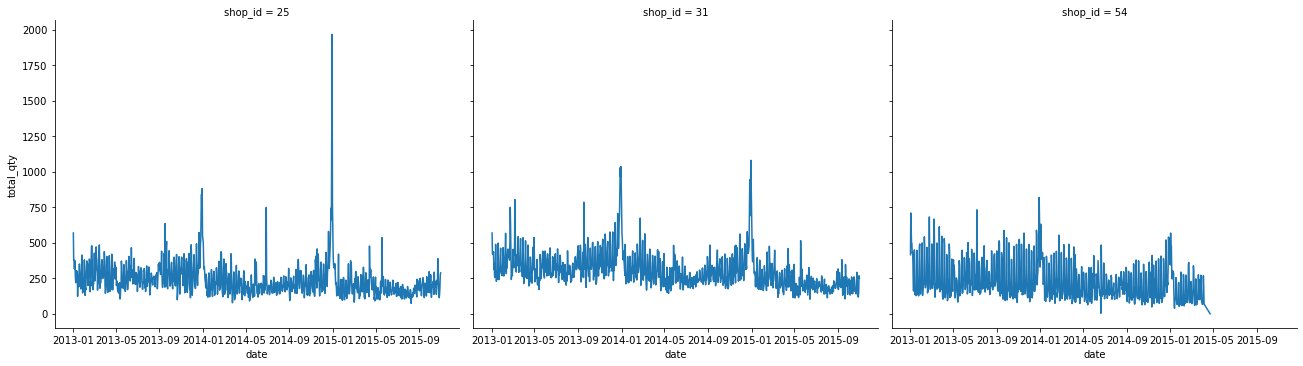

In [16]:
sns.relplot(data=sales_3, kind='line',x='date', y='total_qty', col='shop_id', aspect=6/5)
plt.show()

Disini kita bisa liat dari toko TOP 3 yang tertinggi terlihat bahwa `shop_id` = 25 & 31 terdapat spike pada bulan tertentu

sedangkan untuk `shop_id` 54 tidak terdapat spike seperti `shop_id` = 25 & 31

---
# Multivariate Time Series Analysis

Disini kita ambil salah satu toko untuk dianalisa misal kita ambil toko 31

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
      dtype=object)

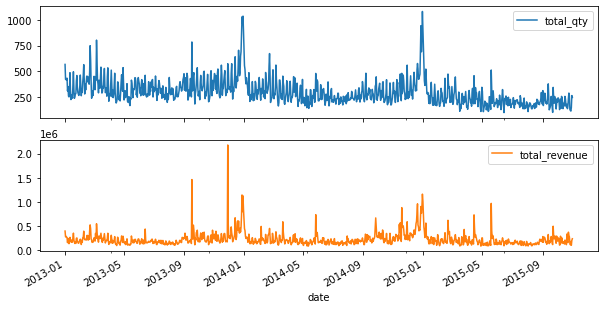

In [17]:
daily_sales_31 = sales_3[sales_3['shop_id'] == 31].reset_index(drop=True)
daily_sales_31.set_index('date')[['total_qty', 'total_revenue']].plot(subplots=True,figsize=(10, 5))

dapat dilihat total qty berpengaruh terhadap total_revenue terlihat ada spike pada waktu2 tertentu

Nah yang kita ambil adalah prediksi total `total_qty` dan `total_revenue` dari tanggal **1 Januari 2013** - **10 Desember 2015** <br>
Akan tetapi pada timeseries ini tgl **1 Januari 2013** itu dobel2 cuy, dikarenakan ada banyak toko disana. Nah kita wajib pilih salah satu toko yang kita mau analisa atau kita rata2kan saja semua toko tersebut untuk tanggal **1 Januari 2013**.

Nah strategi saya adalah mengambil terlebih dahulu salah 1 toko yang memiliki penjualan & revenue paling tinggi dari tanggal **1 Januari 2013** - **10 Desember 2015** dan kita akan membuat prediksi time series dari data toko tersebut.  saya coba ambil toko dengan id = 31 dulu untuk latihan forecast dengan FbProphet

# Mulai modeling dengan FbProphet

Mulai mempersiapkan dataframe-nya untuk ditraining :

- ds: kolom berdurasi waktu, stored di datetime64 data type
- y: value yang mau diforecast <br>

saya pakai total_qty buat di forecast

In [18]:
daily_sales_31.head()

date  shop_id  total_qty  total_revenue
0 2013-01-02       31      568.0      396376.10
1 2013-01-03       31      423.0      276933.11
2 2013-01-04       31      431.0      286408.00
3 2013-01-05       31      415.0      273245.00
4 2013-01-06       31      435.0      260775.00

In [19]:
daily_total_qty_31 = daily_sales_31.rename({'date':'ds', 'total_qty':'y'}, axis = 'columns').drop(['shop_id','total_revenue'], axis = 1)
daily_total_qty_31.head()

ds      y
0 2013-01-02  568.0
1 2013-01-03  423.0
2 2013-01-04  431.0
3 2013-01-05  415.0
4 2013-01-06  435.0

Dataframe sudah kita set menjadi standart di FbProphetnya, Kita mulai melakukan machine learning untuk forecast di tahun **2016**

In [20]:
from fbprophet import Prophet
#prophet reqiures a pandas df at the below config 
# ( date column named as DS and the value column as Y)

model_qty_31 = Prophet(daily_seasonality=True, changepoint_range=0.9) #instantiate Prophet with only yearly seasonality as our data is daily
# changepoint_rrangenya saya set jadi 80% datasetnya
model_qty_31.fit(daily_total_qty_31) #fit the model with your dataframe

Mari kita mulai dengan Forecasting-nya ! untuk shop_id = 31
dengan data yang ada kita pengen nih forecast buat 1 tahun di masa depan (future) tapi intervalnya pe-rhari. klo dulu kita mesti siapin dulu dataframe yang dari time range masa depannya yang mau kita forecast.

In [21]:
# predict for 12 months in the furure and MS - dAY start is the frequency
future_qty_31 = model_qty_31.make_future_dataframe(periods = 365, freq = 'D')  
# now lets make the forecasts
forecast_qty_31 = model_qty_31.predict(future_qty_31)
forecast_qty_31[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
1391 2016-10-26   85.745695   -8.400000  177.396685
1392 2016-10-27   94.270679   -1.013715  185.213367
1393 2016-10-28  178.642857   91.745562  266.637722
1394 2016-10-29  208.599857  117.963713  301.930941
1395 2016-10-30  128.606582   39.551796  215.272417

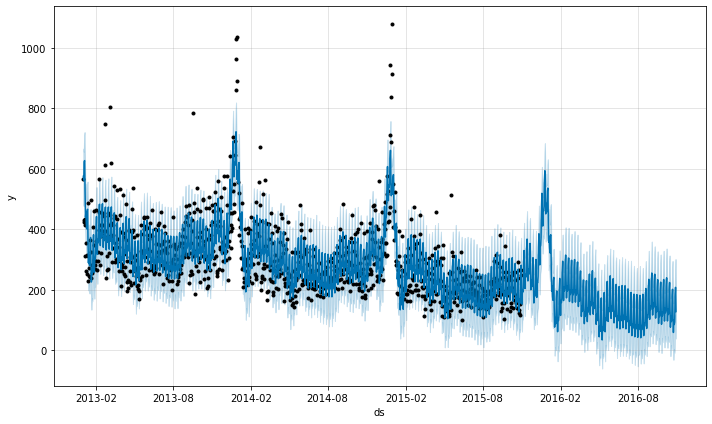

In [22]:
fig = model_qty_31.plot(forecast_qty_31)

disini kita bisa lihat data actual vs prediction-nya dimana :
- data actualnya berupa **scatter**
- data prediksinya berupa **line**

dan kita sudah menggunakan data set total quantity toko 31 **1 Januari 2013 - 10 Desember 2015** untuk memprediksi total quantity toko 31 di tahun **2016**

kita melihat trend dan yearly seasonality, weekly seasonality, daily seasonality

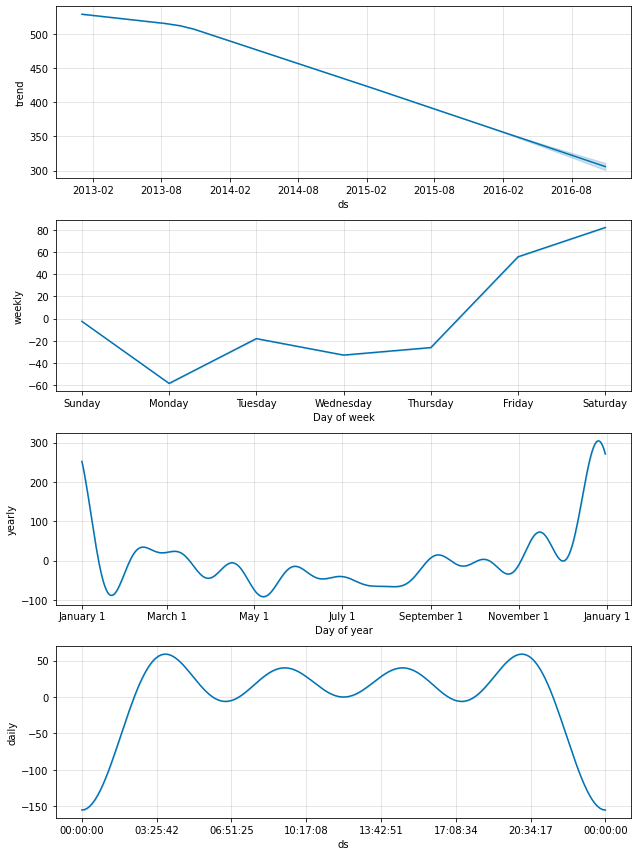

In [23]:
fig = model_qty_31.plot_components(forecast_qty_31)

disini bisa kita analisa bahwa trend penjualan per quantity barang turun setiap waktunya

bisa pakai interactive visualization dengan plotly, grafiknya interactive bisa di-gerak2in

In [24]:
import plotly.io as pio
import plotly.offline as pyo
pio.renderers.default = 'notebook'
pyo.init_notebook_mode()

In [25]:
from fbprophet.plot import plot_plotly, plot_components_plotly
plot_plotly(model_qty_31, forecast_qty_31)

In [26]:
plot_components_plotly(model_qty_31, forecast_qty_31)

# Changepoint Detection

kita bisa melihat titik2 changepoint pada regresi prophet. kyk lihat turning point gitu.
biasanya prophet itu defaultnya naroh 25 changepoint yang tersebar merata 80% dataset kita

saya setelnya 90% dari dataset, biar mirip setting-an Prophet di R

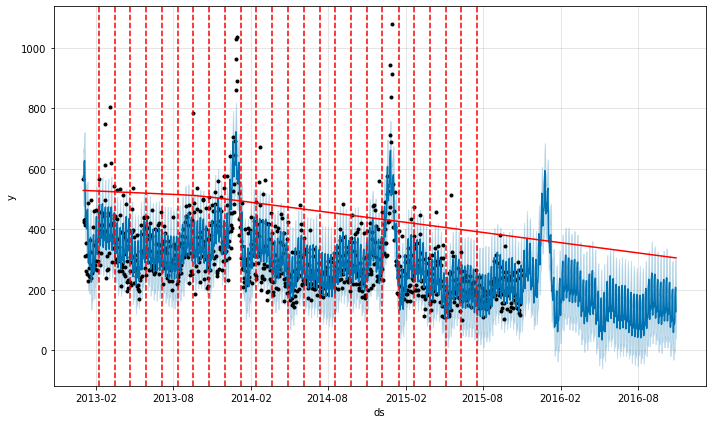

In [27]:
#@title
# for illustration purposes only, threshold = 0
from fbprophet.plot import add_changepoints_to_plot
fig = model_qty_31.plot(forecast_qty_31)
a = add_changepoints_to_plot(fig.gca(), model_qty_31, forecast_qty_31, threshold=0)

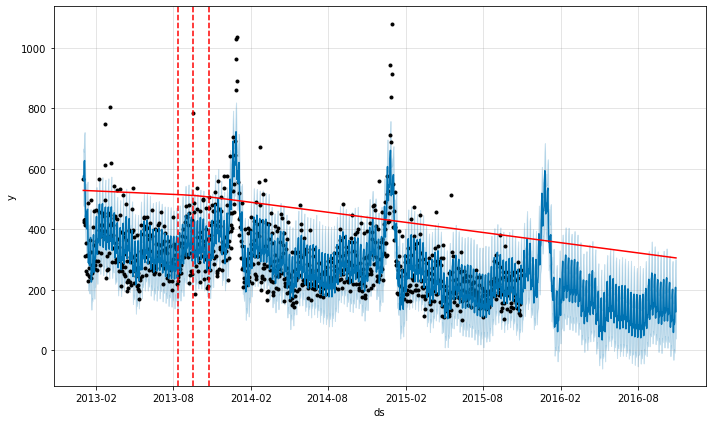

In [28]:
fig = model_qty_31.plot(forecast_qty_31)
a = add_changepoints_to_plot(fig.gca(), model_qty_31, forecast_qty_31)

Prophet detect 3 Significant changepoint

Mulai masuk ke part yang susah. Mulai tuning model machine learningnya

Prophet memberikan flexibilty untuk tuning:

- `n_changepoints` (default = 25): Jumlah potential changepoints, gak recommended buat di tuning, lebih bagus tunning & adjusting regularization `(changepoint_prior_scale)`
- `changepoint_range` (default = 0.8): Proporsi pada timeline dimana trend bisa berubah2. (0.8-0.95) oke
- `changepoint_prior_scale` (default = 0.05): Mementukan flexibilitas dari trend, bagaimana trend berubah di changepoint. Recommended range: [0.001, 0.5]

Menentukan parameter diatas bisa menentukan fleksibilitas dari model (overfitting the training data). Bisa juga value dari trend dibuat jadi agak kaku (underfitting).

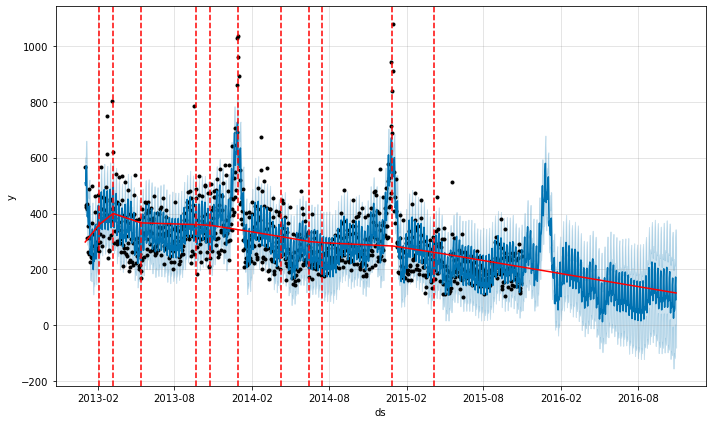

In [29]:
# fitting model
model_tuning_trend = Prophet(
    n_changepoints=25, # default = 25
    changepoint_range=0.8, # default = 0.8
    changepoint_prior_scale=0.5, # default = 0.05
    daily_seasonality=False 
    )
model_tuning_trend.fit(daily_total_qty_31)

# forecasting
future_1_thn = model_tuning_trend.make_future_dataframe(periods=365, freq='D')
forecast_tuning = model_tuning_trend.predict(future_1_thn)

# visualize
fig = model_tuning_trend.plot(forecast_tuning)
a = add_changepoints_to_plot(fig.gca(), model_tuning_trend, forecast_tuning)

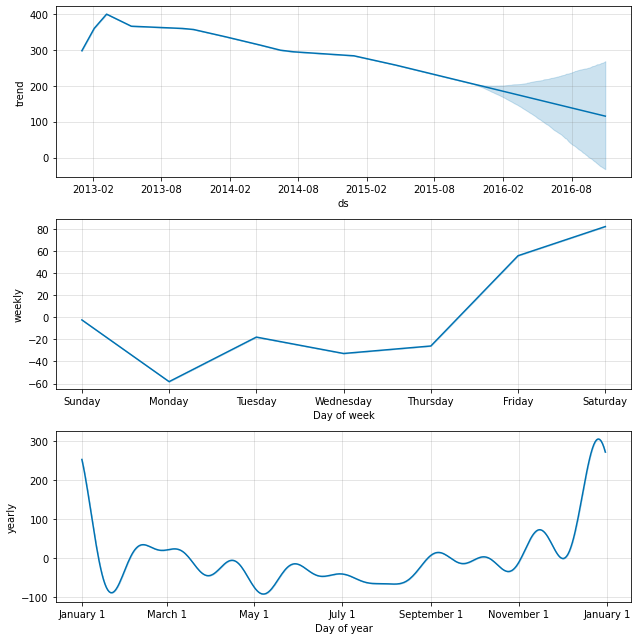

In [30]:
fig = model_qty_31.plot_components(forecast_tuning)

Nentuin seasonality dari FbProphet (year) ngaruh gede bat bro!
holiday juga ngaruh gede juga

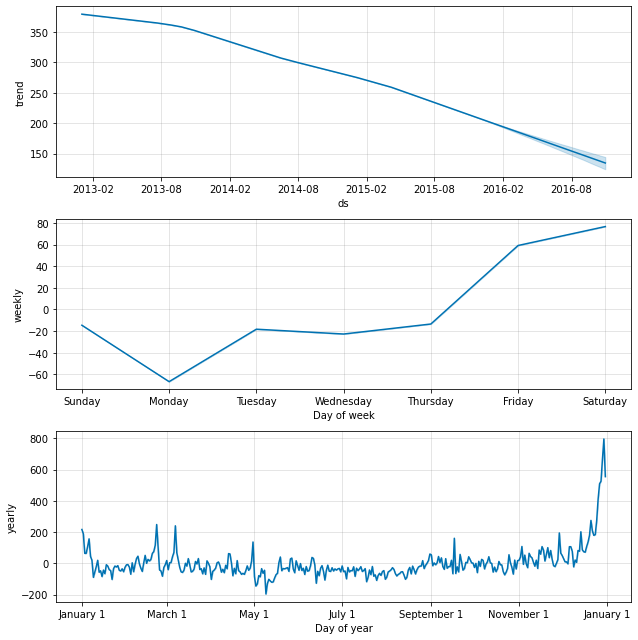

In [31]:
# fitting model
model_tuning_seasonality = Prophet(
    weekly_seasonality=3, # default = 3
    yearly_seasonality=200, # default = 10
    daily_seasonality=False
    )
model_tuning_seasonality.fit(daily_total_qty_31)

# forecasting
future_season = model_tuning_seasonality.make_future_dataframe(periods=365, freq='D')
forecast_season = model_tuning_seasonality.predict(future_season)

# visualize
fig = model_tuning_seasonality.plot_components(forecast_season)

kita melihat ada spike pada tanggal2 tertentu kemungkinan besar itu terjadi dihari libur. Kita cek qty sales diatas 800

In [32]:
daily_total_qty_31[daily_total_qty_31['y'] > 800]

ds       y
64  2013-03-07   803.0
359 2013-12-27   861.0
360 2013-12-28  1028.0
361 2013-12-29   962.0
362 2013-12-30  1035.0
363 2013-12-31   891.0
723 2014-12-27   942.0
725 2014-12-29   839.0
726 2014-12-30  1080.0
727 2014-12-31   912.0

setelah kita cek ternyata sales yang tinggi2 itu kebanyakan tuh ada pada hari2 sebelum tahun baru.

perlu siapin data holiday dataframe :

holiday: Nama holidaynya (yg unique)
ds: timestamp

- lower_window: berapa banyak unit waktu di belakang hari libur yang dianggap terpengaruh (smaller or equal than zero)
- upper_window: berapa banyak unit waktu di setelah hari libur yang dianggap terpengaruh (larger or equal to zero)

In [33]:
holiday = pd.DataFrame({'holiday':'new_year_eve'
                       , 'ds' : pd.to_datetime(['2013-12-31','2014-12-31','2015-12-31'])
                       })
holiday

holiday         ds
0  new_year_eve 2013-12-31
1  new_year_eve 2014-12-31
2  new_year_eve 2015-12-31

In [34]:
holiday = pd.DataFrame({
    'holiday': 'new_year_eve',
    'ds': pd.to_datetime(['2013-12-31', '2014-12-31', # past date, historical data 
                          '2015-12-31']), # future date, to be forecasted
    'lower_window': -4, # include 27th - 31st December
    'upper_window': 0})
holiday

holiday         ds  lower_window  upper_window
0  new_year_eve 2013-12-31            -4             0
1  new_year_eve 2014-12-31            -4             0
2  new_year_eve 2015-12-31            -4             0

abis nyiapin dataframe liburan, lanjut masukin ke class Prophet() :

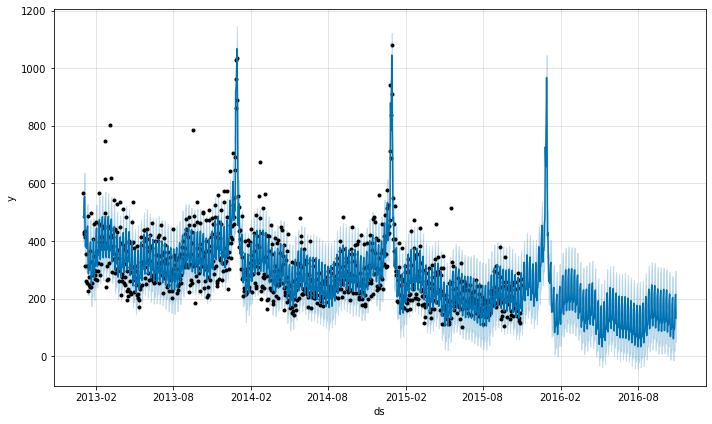

In [35]:
# fitting model
model_holiday = Prophet(daily_seasonality=False,holidays=holiday)
model_holiday.fit(daily_total_qty_31)

# forecasting
future = model_holiday.make_future_dataframe(periods=365, freq='D')
forecast = model_holiday.predict(future)

# visualize
fig = model_holiday.plot(forecast)

grafiknya terlihat lebih konfident (bisa nangkap titik2 di tanggal2 tahun baru)

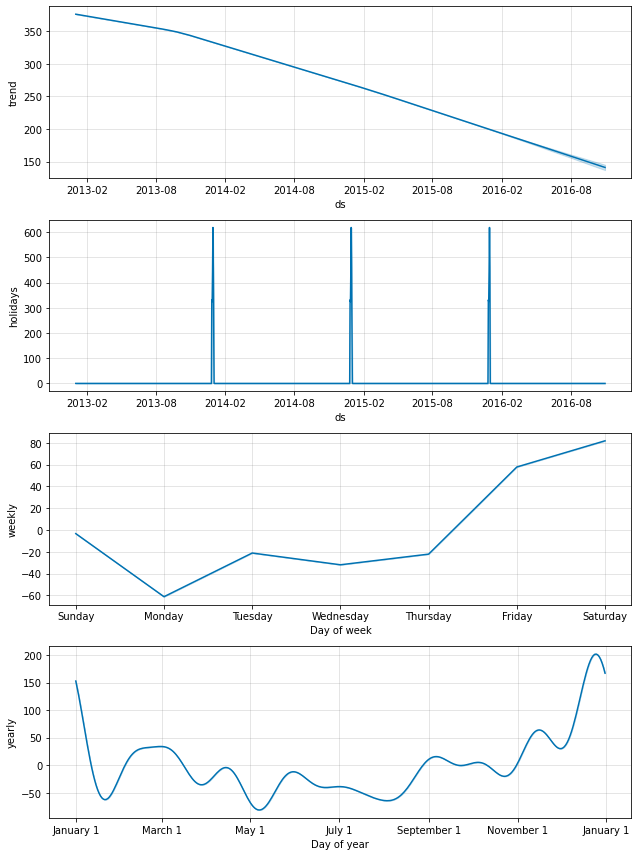

In [36]:
fig = model_holiday.plot_components(forecast)

pecahin data jadi train & test

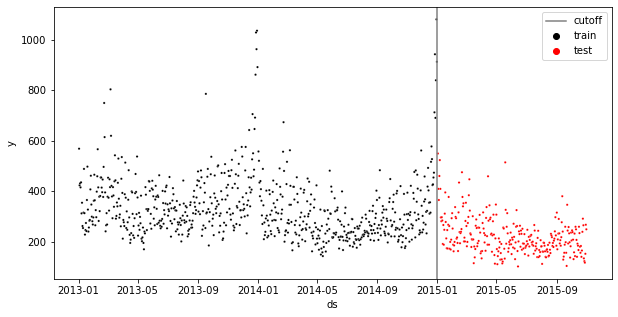

In [37]:
#@title
# for illustration purposes only
cutoff = pd.to_datetime('2015-01-01')
daily_total_qty_31['type'] = daily_total_qty_31['ds'].apply(
    lambda date: 'train' if date < cutoff else 'test')

plt.figure(figsize=(10, 5))
sns.scatterplot(x='ds', y='y', hue='type', s=5,
                palette=['black', 'red'],
                data=daily_total_qty_31)
plt.axvline(x=cutoff, color='gray', label='cutoff')
plt.legend()
plt.show()

In [38]:
train = daily_total_qty_31[daily_total_qty_31['ds'] < cutoff]
test = daily_total_qty_31[daily_total_qty_31['ds'] >= cutoff]

print(f'Train size: {train.shape}')
print(f'Test size: {test.shape}')

Train size: (728, 3)
Test size: (303, 3)


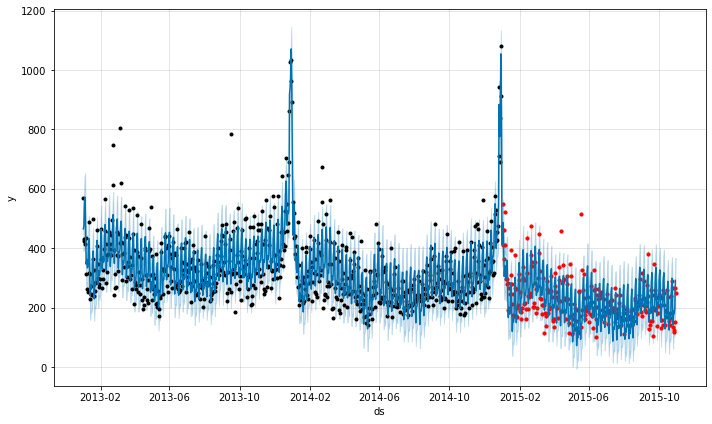

In [39]:
# fitting model
model_final = Prophet(holidays=holiday # holiday effect
                      ,yearly_seasonality=True
                      ,weekly_seasonality=True
                     ,daily_seasonality=True)
model_final.add_seasonality(name='monthly', period=30.5, fourier_order=5) # add monthly seasonality
model_final.fit(train) # only training set

# forecasting
future_final = model_final.make_future_dataframe(periods=303, freq='D') # 303 days (test size)
forecast_final = model_final.predict(future_final)

# visualize
fig = model_final.plot(forecast_final)
plt.scatter(x=test['ds'], y=test['y'], s=10, color='red')
plt.show()

In [40]:
from sklearn.metrics import mean_squared_log_error
forecast_train = forecast_final[forecast_final['ds'] < cutoff]
train_rmsle = mean_squared_log_error(y_true=train['y'],
                                     y_pred=forecast_train['yhat']) ** 0.5
train_rmsle

0.18120498618452416

In [41]:
forecast_test = forecast_final[forecast_final['ds'] >= cutoff]
test_rmsle = mean_squared_log_error(y_true=test['y'],
                                    y_pred=forecast_test['yhat']) ** 0.5
test_rmsle

0.3656945224727956

Here we do cross-validation to assess prediction performance on a horizon of 365 days, starting with 630 days of training data in the first cutoff and then making predictions every 180 days.

In [42]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model_final, initial='630 days', horizon='90 days', period='120 days')
df_cv

INFO:fbprophet:Making 1 forecasts with cutoffs between 2014-10-02 00:00:00 and 2014-10-02 00:00:00


ds         yhat  yhat_lower   yhat_upper       y     cutoff
0  2014-10-03   342.816366  261.993897   424.752448   357.0 2014-10-02
1  2014-10-04   368.203680  284.065145   445.711483   386.0 2014-10-02
2  2014-10-05   287.336565  208.627237   370.723498   279.0 2014-10-02
3  2014-10-06   228.933868  145.516499   308.317123   221.0 2014-10-02
4  2014-10-07   277.629926  203.651978   358.351197   316.0 2014-10-02
..        ...          ...         ...          ...     ...        ...
85 2014-12-27   808.157014  733.943918   889.022796   942.0 2014-10-02
86 2014-12-28   863.959024  779.505689   949.525404   690.0 2014-10-02
87 2014-12-29   821.085708  744.720954   895.172650   839.0 2014-10-02
88 2014-12-30  1021.374442  941.851494  1104.601825  1080.0 2014-10-02
89 2014-12-31   825.419162  741.590071   912.788846   912.0 2014-10-02

[90 rows x 6 columns]

In [43]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv, rolling_window=0)
df_p

horizon           mse        rmse         mae      mape     mdape  coverage
0   1 days    201.175487   14.183634   14.183634  0.039730  0.039730       1.0
1   2 days    316.708994   17.796320   17.796320  0.046104  0.046104       1.0
2   3 days     69.498308    8.336565    8.336565  0.029880  0.029880       1.0
3   4 days     62.946254    7.933868    7.933868  0.035900  0.035900       1.0
4   5 days   1472.262601   38.370074   38.370074  0.121424  0.121424       1.0
..     ...           ...         ...         ...       ...       ...       ...
85 86 days  17913.944838  133.842986  133.842986  0.142084  0.142084       0.0
86 87 days  30261.742034  173.959024  173.959024  0.252115  0.252115       0.0
87 88 days    320.921860   17.914292   17.914292  0.021352  0.021352       1.0
88 89 days   3436.956073   58.625558   58.625558  0.054283  0.054283       1.0
89 90 days   7496.241547   86.580838   86.580838  0.094935  0.094935       1.0

[90 rows x 7 columns]

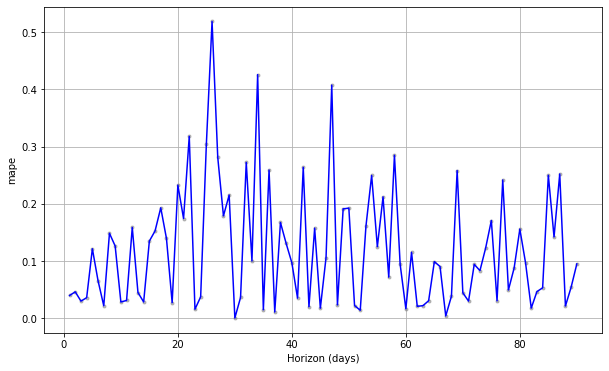

In [44]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape', rolling_window=0)

In [45]:
daily_total_revenue_31 = daily_sales_31.rename({'date':'ds', 'total_revenue':'y'}, axis = 'columns').drop(['shop_id','total_qty'], axis = 1)
daily_total_revenue_31.head()

ds          y
0 2013-01-02  396376.10
1 2013-01-03  276933.11
2 2013-01-04  286408.00
3 2013-01-05  273245.00
4 2013-01-06  260775.00

In [46]:
train_rev = daily_total_revenue_31[daily_total_revenue_31['ds'] < cutoff]
test_rev = daily_total_revenue_31[daily_total_revenue_31['ds'] >= cutoff]

print(f'Train size: {train_rev.shape}')
print(f'Test size: {test_rev.shape}')

Train size: (728, 2)
Test size: (303, 2)


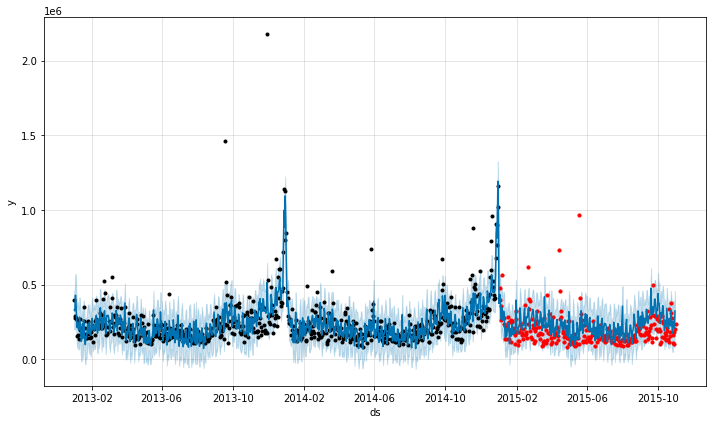

In [47]:
# fitting model
model_final_rev = Prophet(holidays=holiday # holiday effect
                      ,yearly_seasonality=True
                      ,weekly_seasonality=True
                     ,daily_seasonality=True)
model_final_rev.add_seasonality(name='monthly', period=30.5, fourier_order=20) # add monthly seasonality
model_final_rev.fit(train_rev) # only training set

# forecasting
future_final_rev = model_final_rev.make_future_dataframe(periods=303, freq='D') # 303 days (test size)
forecast_final_rev = model_final_rev.predict(future_final)

# visualize
fig = model_final_rev.plot(forecast_final_rev)
plt.scatter(x=test_rev['ds'], y=test_rev['y'], s=10, color='red')
plt.show()